# Импорты

In [5]:
!pip install py7zr -q
!pip install rectools[all] -q

ERROR: Cannot uninstall pybind11 2.12.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps pybind11==2.12.0'.


In [48]:
import numpy as np
import pandas as pd
import py7zr
import seaborn as sns
import matplotlib.pyplot as plt

import implicit

from rectools import Columns
from rectools.dataset import Dataset

from rectools.models import PopularModel

from rectools.models import LightFMWrapperModel
from lightfm import LightFM

from rectools.models import ImplicitALSWrapperModel
from implicit.als import AlternatingLeastSquares


from rectools.metrics import (
    Precision,
    Accuracy,
    NDCG,
    IntraListDiversity,
    Serendipity,
    calc_metrics,
)

# Данные

Для начала просто разархивируем данные

In [7]:
path = '/kaggle/input/kkbox-music-recommendation-challenge/'
files = ['members.csv.7z', 'songs.csv.7z', 'train.csv.7z', 'test.csv.7z']
files = [path+file for file in files]

for file in files:
    with py7zr.SevenZipFile(file, mode='r') as z:
        z.extractall()

In [8]:
members = pd.read_csv('members.csv')
songs = pd.read_csv('songs.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Объединим таблицу train с members и songs, так будет проще работать

In [9]:
df = pd.merge(df, songs, on='song_id', how='left')
del songs

df = pd.merge(df, members, on='msno', how='left')
del members

Посмотрим на пропуски и уникальные значения

In [12]:
dtypes = pd.DataFrame(df.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=df.nunique().sort_values(ascending=True)

dtypes["Null Values"]=df.isnull().sum()

dtypes["% null Values"]=df.isnull().sum()/len(df)

dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='coolwarm',axis=0)

,Data Type,Unique Values,Null Values,% null Values
lyricist,object,33887,3178812,0.430884
gender,object,2,2961479,0.401425
composer,object,76064,1675706,0.227140
source_screen_name,object,20,414804,0.056226
genre_ids,object,572,118455,0.016056
source_system_tab,object,8,24849,0.003368
source_type,object,12,21539,0.002920
language,float64,10,150,0.000020
song_length,float64,60266,114,0.000015
artist_name,object,40582,114,0.000015


В категориальных признаках заполним пропуски как "unknown", а в вещественных средним значением

In [13]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(value = "unknown")    
for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].fillna(value = df[col].mean())

Распарсим даты

In [14]:
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d', errors='ignore')
df['expiration_date'] = pd.to_datetime(df['expiration_date'],  format='%Y%m%d', errors='ignore')

/tmp/ipykernel_452/2923962833.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d', errors='ignore')
/tmp/ipykernel_452/2923962833.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['expiration_date'] = pd.to_datetime(df['expiration_date'],  format='%Y%m%d', errors='ignore')


Зададим новы признаки как день, месяц и год для registration_init_time, expiration_date

In [15]:
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

Посмотрим на получившуюся таблицу

In [16]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


Теперь просто переведем значения категориальных при знаков в числа для удобства

In [17]:
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [18]:
for col in df.select_dtypes(include=['object']).columns[2:]:
    df[col] = df[col].astype('category')
    
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

Уберем target, т.к. у нас задача не такая как в кагл

In [19]:
target = df.pop('target')

Переименуем столбцы в user_id (id пользователя) и item_id (id трека)

In [21]:
df.columns = ['user_id', 'item_id'] + list(df.columns[2:])
df_test.columns = ['user_id', 'item_id'] + list(df_test.columns[2:])

Составим таблицу взаимодействий пользователей с треками. datetime определяем случайным числом, т.к. этот столбец нужен для библиотеки, которую я использую. **В качестве таргета будем считать сколько раз пользователь слушал трек**. Возможно, это довольно наивное предположение, но т.к. рейтингов от пользователей для item_id мы не имеем, то лучше воспользоваться таким предположением

In [22]:
ratings = df.groupby(['user_id', 'item_id']).size().reset_index()
ratings.columns = ['user_id', 'item_id', 'weight']
ratings['datetime'] = 52

Посмотрим на корреляции признаков

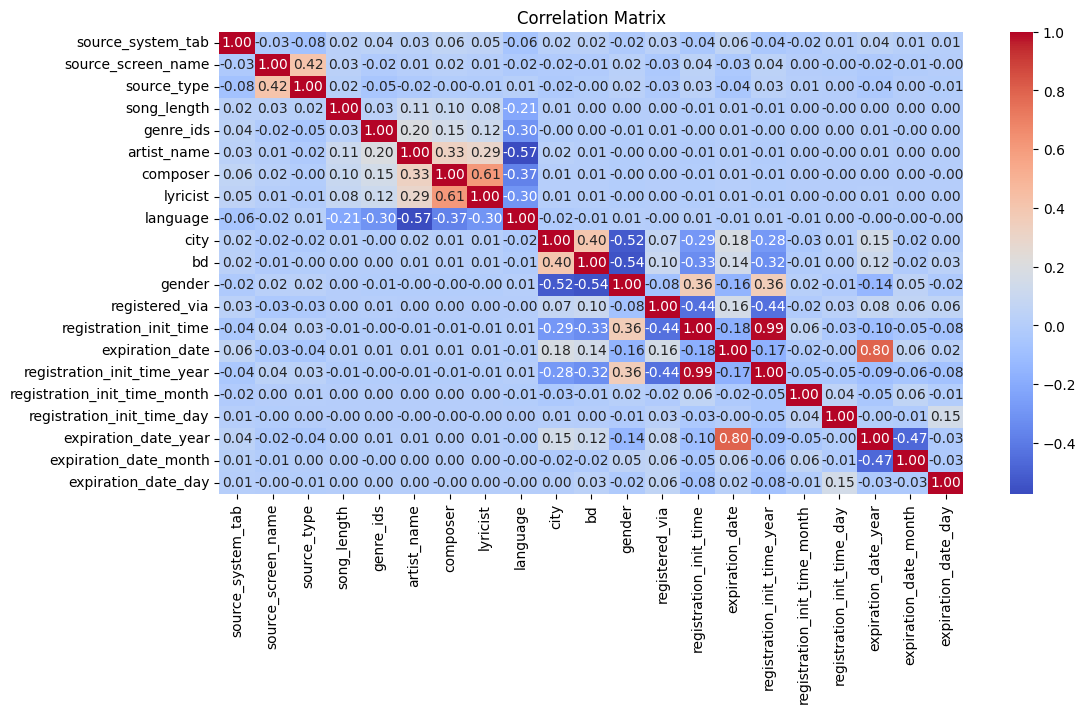

In [75]:
correlation_matrix = df.drop(['user_id', 'item_id'], axis=1).corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Оставим все признаки кроме artist_name (тоже самое, что и item_id), composer, lyricist(они коррелируют с artist). source_system_tab и source_screen_name тоже уберем, они отражают взаимодействие, но я их не использую в своих моделях.

In [23]:
user_features = ['user_id', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 
                 'registration_init_time_year', 'registration_init_time_month', 'registration_init_time_day', 
                 'expiration_date_year', 'expiration_date_month', 'expiration_date_day']
item_features = ['item_id', 'song_length', 'genre_ids', 'language']

Таблицы для пользователей и треков

In [24]:
users = df[user_features]
items = df[item_features]

In [25]:
users = users.drop_duplicates().reset_index().drop('index', axis=1)
items = items.drop_duplicates().reset_index().drop('index', axis=1)

# Модели

Для начала создадим простой датасет, состоящий только из взаимодействий пользователей с item'ами. Без фичей пользователей и item'ов

In [27]:
simple_dataset = Dataset.construct(ratings)

## Первая модель

Обучим baseline модель, которая будет находить самые популярные треки и предлагать их всем

In [29]:
model = PopularModel()
model.fit(simple_dataset)
recos = model.recommend(
    users=ratings[Columns.User].unique(),
    dataset=simple_dataset,
    k=50,
    filter_viewed=True
)

In [30]:
ndcg = NDCG(k=20, log_base=2)

In [34]:
df_test = df_test.drop('user_id', axis=1)
df_test.columns = ['user_id', 'item_id'] + list(df_test.columns[2:])

In [36]:
ndcg_baseline = ndcg.calc(reco=recos, interactions=df_test)
print("NDCG: ", ndcg_baseline)

NDCG:  0.08776923068680294


От этого значения будем отталкиваться в дальнейшем

Зададим датасет с фичами пользователей и треков

In [37]:
dense_features_dataset = Dataset.construct(
    ratings,
    user_features_df=users,
    cat_user_features=['city', 'gender', 'registered_via'],
    item_features_df=items,
    cat_item_features=['genre_ids', 'language'],
    make_dense_user_features=True,
    make_dense_item_features=True
)

Снова обучим такую же модель

In [44]:
from rectools.models import PopularModel

model = PopularModel()
model.fit(dense_features_dataset)
recos = model.recommend(
    users=ratings[Columns.User].unique(),
    dataset=dense_features_dataset,
    k=50,
    filter_viewed=True
)

In [45]:
ndcg_popular = ndcg.calc(reco=recos, interactions=df_test)
print("NDCG: ", ndcg_popular)

NDCG:  0.08776923068680294


Получилось то же самое, что логично, т.к. модель просто ищет популярные треки

## Вторая модель

Теперь обучим модель LightFM и сравним результат с baseline'ом

In [56]:
model = LightFMWrapperModel(
        model=LightFM(no_components = 30)
        )

model.fit(simple_dataset)
recos = model.recommend(
    users=ratings[Columns.User].unique(),
    dataset=simple_dataset,
    k=50,
    filter_viewed=True
)

In [58]:
ndcg_lfmw_simple = ndcg.calc(reco=recos, interactions=df_test)
print("NDCG: ", ndcg_lfmw_simple)

NDCG:  0.08781778115586768


Как видим результат слегка улучшился

Возьмем датасет с фичами

In [46]:
model = LightFMWrapperModel(
        model=LightFM(no_components = 30)
        )

model.fit(dense_features_dataset)
recos = model.recommend(
    users=ratings[Columns.User].unique(),
    dataset=dense_features_dataset,
    k=50,
    filter_viewed=True
)

In [47]:
ndcg_lfmw = ndcg.calc(reco=recos, interactions=df_test)
print("NDCG: ", ndcg_lfmw)

NDCG:  1.3077462324450675e-06


Метрика сильно уменьшилась. Возможно признаки лишь вносят шум (получаются слишком разреженные матрицы).

## Третья модель

Обучим ALS на простом датасете

In [49]:
model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=64,
            regularization=0.01,
            alpha=1,
            random_state=2024,
            use_gpu=False,
            iterations=15))

model.fit(simple_dataset)
recos = model.recommend(
    users=ratings[Columns.User].unique(),
    dataset=simple_dataset,
    k=50,
    filter_viewed=True
)

In [50]:
ndcg_als_simple = ndcg.calc(reco=recos, interactions=df_test)
print("NDCG: ", ndcg_als_simple)

NDCG:  0.10486638819031124


Лучшая из всех метрик

Добавим фичи и снова обучим ALS

In [51]:
model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=64,
            regularization=0.01,
            alpha=1,
            random_state=2024,
            use_gpu=False,
            iterations=15))
model.fit(dense_features_dataset)
recos = model.recommend(
    users=ratings[Columns.User].unique(),
    dataset=dense_features_dataset,
    k=50,
    filter_viewed=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
ndcg_als = ndcg.calc(reco=recos, interactions=df_test)
print("NDCG: ", ndcg_als)

NDCG:  2.931997903457805e-06


Значение метрика снова сильно снизилось

# Итоги

Сравним результаты

In [78]:
models = ['Popular without features(baseline)', 'Popular with features', 'LFM without features', 'LFM with features',
         'ALS without features', 'ALS with features']
pd.DataFrame(index=models, columns=['NDCG@20'],
             data=[ndcg_baseline, ndcg_popular, ndcg_lfmw_simple, ndcg_lfmw, ndcg_als_simple, ndcg_als]).style.background_gradient(cmap='coolwarm',axis=0)

,NDCG@20
Popular without features(baseline),0.087769
Popular with features,0.087769
LFM without features,0.087818
LFM with features,0.000001
ALS without features,0.104866
ALS with features,0.000003


**Вывод:** Лучше всех справилась модель ALS без дополнительных признаков. Похоже, что дополнительные признаки, действительно вносят шум из-за чего предсказания хуже